<a href="https://colab.research.google.com/github/Josepholaidepetro/Reading-Digits-in-Natural-Scene-Images/blob/main/notebooks/ICL_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from scipy.io import loadmat
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [3]:
!wget "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

--2021-11-16 07:03:26--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  14.9MB/s    in 5.3s    

2021-11-16 07:03:32 (11.6 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]



In [4]:
!wget "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"

--2021-11-16 07:03:32--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  18.1MB/s    in 11s     

2021-11-16 07:03:43 (16.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]



For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [5]:
# Load the dataset from your Drive folder

train = loadmat('/content/train_32x32.mat')
test = loadmat('/content/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset

In [6]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [7]:

X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']


In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032), (73257, 1), (26032, 1))

In [9]:
X_train = np.moveaxis(X_train, 3, 0)
X_test = np.moveaxis(X_test, 3 , 0)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3), (73257, 1), (26032, 1))

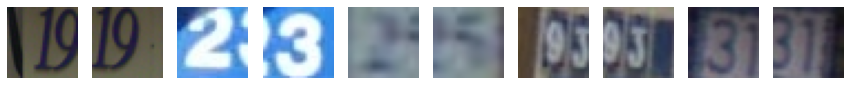

In [13]:
fig, ax = plt.subplots(1, 10, figsize=(15, 10))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])

In [14]:
X_train_grays = np.mean(X_train, 3)
X_test_grays = np.mean(X_test,3)

X_train_grayscale = X_train_grays.reshape(73257, 32, 32, 1)/255
X_test_grayscale = X_test_grays.reshape(26032, 32,32 ,1)/255

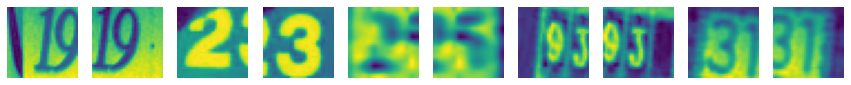

In [15]:
fig, ax = plt.subplots(1, 10, figsize=(15, 10))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(np.mean(X_train,3)[i])

In [16]:
result = np.where(y_train == 10)
result

(array([   52,    84,    93, ..., 73193, 73220, 73239]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [18]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

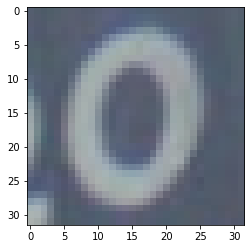

In [19]:
plt.imshow(X_train[73220])

In [20]:
np.unique(y_test)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [21]:
Y_train = np.where(y_train==10, 0, y_train)
Y_test = np.where(y_test==10, 0, y_test)

## 2. MLP neural network classifier

In [22]:
from keras.utils import np_utils

Y_train = np_utils.to_categorical(Y_train, 10)    # encode to_categorical variable
Y_test = np_utils.to_categorical(Y_test, 10)

In [24]:
Y_test[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [25]:
X_train[0].shape

(32, 32, 3)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout


def get_new_model():
    model = Sequential([
        Flatten(input_shape=X_train[0].shape, name='flatten'),
        Dense(units=1024, activation='relu', name='dense_1'),
        Dense(units=512, activation='relu', name='dense_2'),
        Dense(units=256, activation='relu', name='dense_3'),
        Dense(units=128, activation='relu', name='dense_4'),
        Dense(units=10, activation='softmax', name='dense_5')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [27]:
def get_test_perfomance(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {loss:0.3f}'.format(loss=test_loss))

In [28]:
Y_test.shape

(26032, 10)

In [29]:
model = get_new_model()

In [31]:
model.summary()
get_test_perfomance(model, X_test, Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              3146752   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,837,066
Trainable params: 3,837,066
Non-

In [32]:
def get_checkpoint_best_only():
    """
    This function returnS a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_best_path = 'checkpoints_bestmlp_only/checkpoint'

    checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path , save_weights_only=True,
                                  save_best_only = True, verbose=1,save_freq='epoch', monitor= 'val_loss')
    
    return checkpoint_best

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=4,monitor='val_loss', mode='min')
    return early_stopping

In [33]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [34]:
callbacks = [checkpoint_best_only, early_stopping]
history = model.fit(X_train, Y_train, epochs=30,batch_size=128, 
                    validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/30
572/573 [============================>.] - ETA: 0s - loss: 25.0854 - accuracy: 0.1781
Epoch 00001: val_loss improved from inf to 2.10704, saving model to checkpoints_bestmlp_only/checkpoint
573/573 [==============================] - 6s 9ms/step - loss: 25.0725 - accuracy: 0.1782 - val_loss: 2.1070 - val_accuracy: 0.2749
Epoch 2/30
570/573 [============================>.] - ETA: 0s - loss: 1.6714 - accuracy: 0.4377
Epoch 00002: val_loss improved from 2.10704 to 1.54284, saving model to checkpoints_bestmlp_only/checkpoint
573/573 [==============================] - 6s 10ms/step - loss: 1.6706 - accuracy: 0.4382 - val_loss: 1.5428 - val_accuracy: 0.5204
Epoch 3/30
567/573 [============================>.] - ETA: 0s - loss: 1.3032 - accuracy: 0.5861
Epoch 00003: val_loss improved from 1.54284 to 1.31096, saving model to checkpoints_bestmlp_only/checkpoint
573/573 [==============================] - 6s 10ms/step - loss: 1.3022 - accuracy: 0.5864 - val_loss: 1.3110 - val_accuracy: 0.

In [35]:
!ls /content/checkpoints_bestmlp_only

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


In [36]:
get_test_perfomance(model , X_test, Y_test)

accuracy: 0.658
loss: 1.158


In [37]:
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,25.072495,0.178167,2.107036,0.274854
1,1.670550,0.438197,1.542838,0.520398
2,1.302193,0.586374,1.310961,0.603411
3,1.194430,0.626698,1.316956,0.599570
4,1.133616,0.649522,1.320330,0.595536


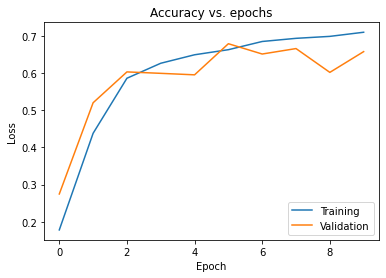

In [38]:
#Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## 3. CNN neural network classifier

In [39]:
def get_newcnn_model():
    model = Sequential([
        Conv2D(filters=128, input_shape=X_train[0].shape, kernel_size=(3, 3), padding='SAME',
               activation='relu', name='conv_1'),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.25),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='SAME', name='conv_2'),
        MaxPooling2D(pool_size=(2, 2), name='pool_1'),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.25),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='SAME', name='conv_3'),
        MaxPooling2D(pool_size=(2, 2), name='pool_2'),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.25),
        Flatten(name='flatten'),
        Dense(units=256, activation='relu', name='dense_1'),
        Dropout(0.5),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [40]:
model2 = get_newcnn_model()

In [41]:
model2.summary()
get_test_perfomance(model2, X_test, Y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 128)       147584    
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                      

In [42]:
def get_checkpoint_best_only():
    """
    This function returnS a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_best_path = 'checkpoints_best_only/checkpoint'

    checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path , save_weights_only=True,
                                  save_best_only = True, verbose=1,save_freq='epoch', monitor= 'val_accuracy')
    
    return checkpoint_best

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=4,monitor='val_accuracy', mode='max')
    return early_stopping

In [43]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [44]:
callbacks = [checkpoint_best_only, early_stopping]
history = model2.fit(X_train, Y_train, epochs=30,batch_size=128,
                    validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/30
573/573 [==============================] - ETA: 0s - loss: 1.7006 - accuracy: 0.4083
Epoch 00001: val_accuracy improved from -inf to 0.80220, saving model to checkpoints_best_only/checkpoint
573/573 [==============================] - 50s 82ms/step - loss: 1.7006 - accuracy: 0.4083 - val_loss: 0.6862 - val_accuracy: 0.8022
Epoch 2/30
572/573 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.8006
Epoch 00002: val_accuracy improved from 0.80220 to 0.86067, saving model to checkpoints_best_only/checkpoint
573/573 [==============================] - 47s 83ms/step - loss: 0.6517 - accuracy: 0.8006 - val_loss: 0.4778 - val_accuracy: 0.8607
Epoch 3/30
572/573 [============================>.] - ETA: 0s - loss: 0.5083 - accuracy: 0.8466
Epoch 00003: val_accuracy improved from 0.86067 to 0.88111, saving model to checkpoints_best_only/checkpoint
573/573 [==============================] - 46s 80ms/step - loss: 0.5083 - accuracy: 0.8466 - val_loss: 0.4091 - val_accura

In [45]:
!ls /content/checkpoints_best_only

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


In [46]:
get_test_perfomance(model2,X_test, Y_test)

accuracy: 0.925
loss: 0.336


In [47]:
df2 = pd.DataFrame(history.history)
df2.head()

,loss,accuracy,val_loss,val_accuracy
0,1.700585,0.408289,0.686212,0.802205
1,0.651679,0.800606,0.477825,0.860671
2,0.508301,0.846622,0.409100,0.881108
3,0.432949,0.869009,0.393337,0.882568
4,0.387152,0.883683,0.339922,0.901083


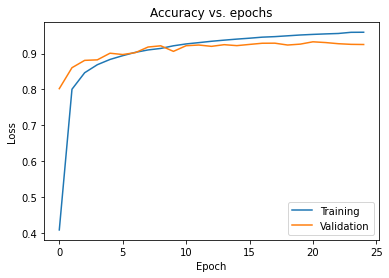

In [48]:
#Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

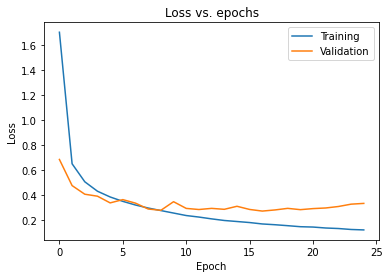

In [49]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.

**Loading the best weights for the CNN models**

In [51]:
checkpoint_best_path = 'checkpoints_best_only/checkpoint'

model_best_path = get_newcnn_model()
model_best_path.load_weights(checkpoint_best_path)
get_test_perfomance(model_best_path, X_test, Y_test)

accuracy: 0.933
loss: 0.294


Loading the weights for the MLP models

In [53]:
checkpoint_bestmlp_path = 'checkpoints_bestmlp_only/checkpoint'

model_mlp_path = get_new_model()
model_mlp_path.load_weights(checkpoint_bestmlp_path)
get_test_perfomance(model_mlp_path, X_test, Y_test)

accuracy: 0.679
loss: 1.083


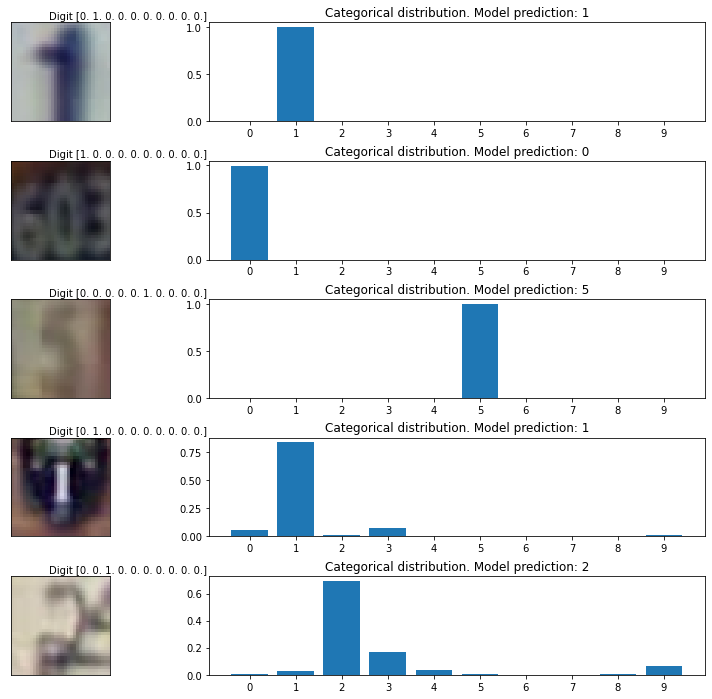

In [ ]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = Y_test[random_inx, ...]

predictions = model_best_path.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(12., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()